In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import time
import math
import os
import sys
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

sys.path.insert(0, '../')
from utils import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from bayesian_model_evidence import log_evidence

from skimage.restoration import estimate_sigma
import bm3d
from kneed import KneeLocator

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from rdata import read_rds
from selective_inference import forward_stop_rule

from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.linear_model import lars_path
from abess import LinearRegression as AbessLinearRegression
from knockpy import KnockoffFilter, knockoff_stats, knockoffs
from knockpy.utilities import estimate_covariance
from scipy import stats
from statsmodels.stats.multitest import multipletests
from c2st.check import c2st # https://github.com/psteinb/c2st

from mbic import mbic, mbic2, ebic

from rdata import read_rds
from selective_inference import forward_stop_rule, sfs_si, stepwise_selective_inference, subset_fdr
import fpsample
from dppy.finite_dpps import FiniteDPP

from si4pipeline import (
                        construct_pipelines, 
                        extract_features, 
                        initialize_dataset, 
                        intersection, 
                        lasso, 
                        marginal_screening, 
                        stepwise_feature_selection, 
                        union, 
                        PipelineManager
                        )

alibi is not installed in the environment.


In [2]:
target_name = 'v'
X_pre = np.load("../Cache/X_pre_RD_2025.npy")
y_pre = np.load("../Cache/y_pre_RD_2025.npy")
u_pre = y_pre.copy()
if target_name == 'u':
    y_pre = y_pre[:, 0:1]
elif target_name == 'v':
    y_pre = y_pre[:, 1:2]
else:
    raise ValueError("target_name is either 'u' or 'v'.")
feature_names = np.load("../Cache/feature_names_RD_2025.npy", allow_pickle=True)
# R
fsInf = read_rds(f"../R/R_data/fsInf_screening_RD_{target_name}.rds")

### Python

In [3]:
n_terms = 16
max_complexity = 12
alphas = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]

_, lars_p, _ = lars_path(StandardScaler().fit_transform(X_pre), y_pre.flatten(), method='lasso', alpha_min=1e-6)
lars_p = np.array(list(map(int, lars_p)))[:n_terms]
X_test = X_pre[:, lars_p]
sigma = np.std(y_pre-X_test@np.linalg.lstsq(X_test, y_pre)[0], ddof=1)
manager = stepwise_selective_inference(support_size=len(lars_p))
_, p_list = manager.inference(X_test, y_pre, sigma)
print(lars_p, p_list, subset_fdr(p_list))

for alpha in alphas:
    adjusted_pvalues = p_list
    stop_step, false_discovery_rates = forward_stop_rule(adjusted_pvalues, alpha)
    adjusted_pvalues = adjusted_pvalues[:stop_step+1]
    rejections = np.sort(lars_p[:stop_step+1])
    if len(rejections) <= max_complexity: 
        break
max_fdr = alpha
max_fdr, feature_names[rejections]

[ 0 12 11 18 17  1  5  7 16  4 15 14  6  8 13  9] [0.0, 0.0, 5.969827965301988e-10, 0.0, 4.961587807272849e-10, 0.0, 0.0, 0.0, 0.364187135066689, 0.0661404469806165, 0.792311483755519, 0.14625498095188172, 0.0, 0.0, 0.06000727958360086, 0.11856310816840354] 0.15245023641639083


(0.15,
 array(['x0', 'x1', 'x1^2', 'x0^3', 'x0 x1^2', 'x0_22', 'x1_22', 'x1_12',
        'x0_11', 'x1_11'], dtype='<U7'))

### R

In [4]:
# max_complexity = 12
# alphas = [0.3, 0.2, 0.1, 0.05, 0.01]
# for alpha in alphas:
#     adjusted_pvalues = fsInf.get("pv")
#     stop_step, false_discovery_rates = forward_stop_rule(adjusted_pvalues, alpha)
#     adjusted_pvalues = adjusted_pvalues[:stop_step+1]
#     rejections = np.sort((fsInf.get("vars")-1).astype(np.int32)[:stop_step+1])
#     if len(rejections) <= max_complexity:
#         break
# max_fdr = alpha
# feature_names[rejections]

In [5]:
X_pre_top = X_pre[:, rejections]
X_pre_top = X_pre_top/np.linalg.norm(X_pre_top, 2, axis=0)

In [6]:
_, best_subsets = brute_force_all_subsets(X_pre_top, y_pre, max_support_size=8)

ebics = []
mbics = []
for _ in best_subsets:
    loglik = log_like_value(X_pre_top[:, _]@np.linalg.lstsq(X_pre_top[:, _], y_pre, rcond=None)[0], 
                            y_pre)
    ebics.append(ebic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=0))
    mbics.append(mbic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=2))

100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.48it/s]


In [7]:
np.random.seed(0); random.seed(0)
n_samples = 250*(knee_finder(mbics)+1)
false_discovery_control_method = 'bh'
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        # print(M, p_list, np.array(p_list) < 0.05)
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    print(fdrs.mean(), stats.wilcoxon(fdrs-max_fdr, alternative='less').pvalue)

0.0 0.015625
0.3833960157283945 1.0
0.779319370524521 1.0
0.6780618423246548 1.0
1.0589469019091098 1.0
2.236269542196407 1.0
0.11625510885828975 0.015625
1.091452984934892 1.0


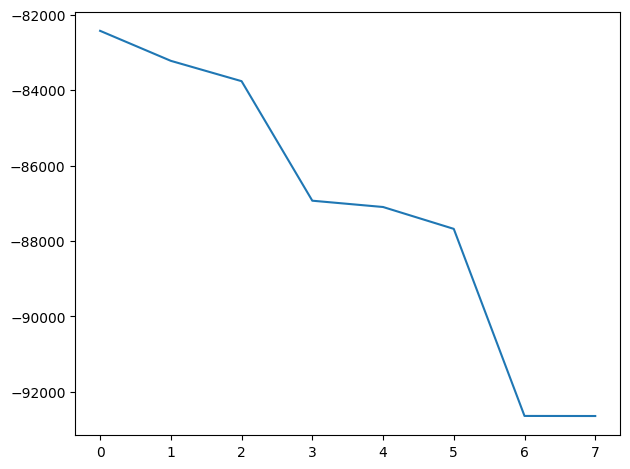

In [8]:
plt.plot(mbics); plt.show()